In [18]:
%pylab
%matplotlib inline


Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# The Dispersion Relation
The _dispersion relation_ is the function that relates the frequency $\omega$ and the wavevector $k$. It characterizes each wave type and leads to the labels for the various type.


 - CMA diagram
 - phase velocity vs normalized frequency
 - normalized or not
 - density
 - angle
 - field strength
 
 - transverse motions of the electrons on cyclotron resonance sec.2.9.3

The plasma pulsation is :
$$
\omega_{p_s} = \sqrt{\frac{n_s q_s^2}{m_s \varepsilon_0}}
$$

In [52]:
from scipy.constants import epsilon_0

def plasma_frequency(n, q, m):
    '''
    Returns the plasma angular frequency for a given species.
    '''
    omega_p = sqrt(n*q**2/(m*epsilon_0))
    return omega_p

def cyclotron_frequency(q, m, B0):
    '''
    Returns the cyclotron angular frequency for a given species.
    '''
    omega_c = np.abs(q)*B0/m
    return omega_c

Let's define a convenient object: a particle species.

In [53]:
class Species:
    def __init__(self, m, q, description=None):
        self.m = m
        self.q = q
        self.description = description
    def omega_p(self, n):
        return plasma_frequency(n, self.q, self.m)
    def omega_c(self, B0):
        return cyclotron_frequency(self.q, self.m, B0)
    def __repr__(self):
        return 'Specie:{}. Mass:{} kg, charge:{} C'.format(self.description, self.m, self.q)

In [54]:
from scipy.constants import electron_mass, elementary_charge

electron = Species(electron_mass, -elementary_charge, description='Electron')
print(electron)

deuterium = Species(pc['deuteron mass'][0], +elementary_charge, description='Deuterium')
print(deuterium)

Specie:Electron. Mass:9.10938291e-31 kg, charge:-1.602176565e-19 C
Specie:Deuterium. Mass:3.34358348e-27 kg, charge:1.602176565e-19 C


## The cold plasma tensor
The cold plasma tensor is given by:
$$
\mathbf{K} = \left(
\begin{matrix}
K_\perp & K_\times & 0 \\
-K_\times & K_\perp & 0 \\
0 & 0 & K_\parallel
\end{matrix}
\right)
$$
with
$$
\begin{array}{lcl}
K_\perp = S &=& 1 - \displaystyle \sum_k  \frac{\omega_{pk}^2}{\omega^2 - \omega_{ck}^2}
\\
i K_\times = D &=& \displaystyle \sum_k \frac{\epsilon_k \omega_{ck} \omega_{pk}^2}
{\omega \left( \omega^2 - \omega_{ck}^2\right)}
\\
K_\parallel = P &=& 1 - \displaystyle \sum_k \frac{\omega_{pk}^2}{\omega^2}
\end{array}
$$

In [55]:
def K_perp(species, n, B0, f):
    K_perp = 1
    omega = 2*np.pi*f

    for k, specie in enumerate(species):
        K_perp -= specie.omega_p(n[k])**2 / (omega**2 - specie.omega_c(B0)**2)        
    return K_perp

def K_parallel(species, n, f):
    K_parallel = 1
    omega = 2*np.pi*f
    for k,specie in enumerate(species):
        K_parallel -= specie.omega_p(n[k])**2 / omega**2
    return K_parallel

def K_cross(species, n, B0, f):
    K_cross = 0
    omega = 2*np.pi*f

    for k, specie in enumerate(species):
        K_cross +=  np.sign(specie.q) * specie.omega_c(B0) * specie.omega_p(n[k])**2 / (omega*(omega**2 - specie.omega_c(B0)**2))        
    return -1j*K_cross

In [56]:
plasma = (electron, deuterium)
n_e = 1e17 # m^-3
n_D = 1e17 # m^-3
n = (n_e, n_D)
B0 = 1 # T
f = 5e9 # Hz
print(K_perp(plasma, n, B0, f))
print(K_parallel(plasma, n, f))
print(K_cross(plasma, n, B0, f))
np.sign(electron.q)

1.01053942772
0.677446602046
-0.059496951326968084j


-1.0

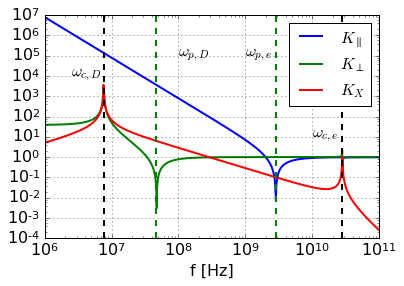

In [76]:
freqs = np.logspace(6, 11, 1001)
loglog(freqs, abs(K_parallel(plasma, n, freqs)), lw=2)
loglog(freqs, abs(K_perp(plasma, n, B0, freqs)), lw=2)
loglog(freqs, abs(1j*K_cross(plasma, n, B0, freqs)), lw=2)
xlabel('f [Hz]', fontsize=16)
yticks(fontsize=16)
xticks(fontsize=16)
grid(True)
legend(('$K_\parallel$', '$K_\perp$', '$K_X$' ), fontsize=16)

axvline(deuterium.omega_c(B0)/(2*pi), lw=2, ls='--', color='k')
text(x=2.5e6, y=1e4, s='$\omega_{c,D}$', fontsize=16)
axvline(deuterium.omega_p(n_e)/(2*pi), lw=2, ls='--', color='g')
text(x=1e8, y=1e5, s='$\omega_{p,D}$', fontsize=16)
axvline(electron.omega_p(n_e)/(2*pi), lw=2, ls='--', color='g')
text(x=1e9, y=1e5, s='$\omega_{p,e}$', fontsize=16)
axvline(electron.omega_c(B0)/(2*pi), lw=2, ls='--', color='k')
text(x=1e10, y=1e1, s='$\omega_{c,e}$', fontsize=16)

In [57]:
def solve_dispersion_relation(plasma, n, B0, f, theta):
    S = K_perp(plasma, n, B0, f)
    P = K_parallel(plasma, n, f)
    D = 1j*K_cross(plasma, n, B0, f)
    
    R = S+D
    L = S-D
    
    A = S*np.sin(theta)**2 + P*np.cos(theta)**2
    B = R*L*np.sin(theta)**2 + P*S*(1+np.cos(theta)**2)
    C = P*R*L
    p = (A,B,C)
    n = np.roots(p)
    
    return n

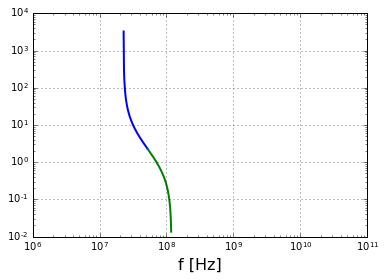

In [87]:
diel_index = np.array([solve_dispersion_relation(plasma, n, B0=3, f=f, theta=0) for f in freqs])

loglog(freqs, real(diel_index[:,0]), lw=2)
loglog(freqs, real(diel_index[:,1]), lw=2)
grid(True)
xlabel('f [Hz]', fontsize=16)

# References
 - Swanson, Plasma Waves, chap.2